
# Test clouds: Ridge functions


### JAH, May 2021

In [1]:
%matplotlib inline
#%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges      as ridges
import clouds.test_ridges as tridges

In [3]:
plt.rcParams['image.cmap'] = 'rainbow'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May 19 11:58:59 2021


## Test

   * Generate a 2D and 3D function with know gradient, laplacian, eigenvalues and ridge
   
   * Validate gradient, laplacian, eigenvalues, ridge
   
   * Define a Ridge filter


## Generate Function

## Generate sample

In [56]:
y0 = 4
fun = lambda x, y : x - (y - y0)**2
xrange = (0, 10)
yrange = (0, 10)
nbins  = 41

In [57]:
bins, cells, img, xmesh = tridges.generate_image(nbins, (xrange, yrange), fun)
centers = [clouds.ut_centers(ibin) for ibin in bins]

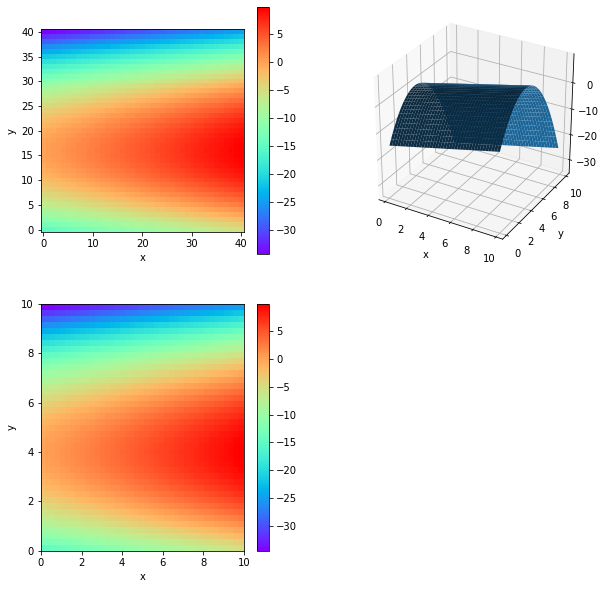

In [58]:
fig = plt.figure(figsize = (10, 10))

ax0  = plt.subplot(2, 2, 1)
# as the img has ij access, draw it in 'cartesian' with transpose and set the origin at the cartesian origin
plt.imshow(img.T, origin = 'lower'); # change the origin
#plt.colorbar(p);
plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();

ax1 = fig.add_subplot(2, 2, 2, projection = '3d')
ax1.plot_surface(*xmesh, img);
plt.xlabel('x'); plt.ylabel('y');


# make a 2D histogram
ax1 = fig.add_subplot(2, 2, 3)
counts, _, _, _  = plt.hist2d(xmesh[0].flatten(), xmesh[1].flatten(), bins, weights = img.flatten()); 
plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();

# ensure that counts from a histogram is equivalent to img!
assert (np.all(img == counts)) 

### Test the messhes

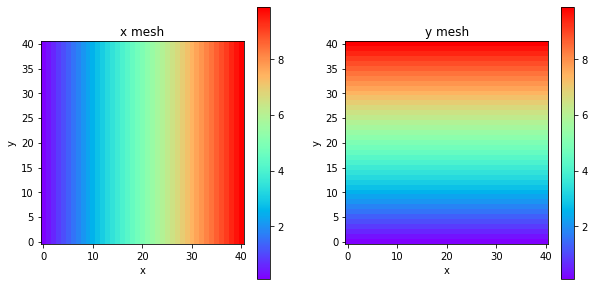

In [59]:
fig = plt.figure(figsize = (10, 5))

ax0  = plt.subplot(1, 2, 1)
plt.imshow(xmesh[0].T, origin = 'lower'); # change the origin
plt.xlabel('x'); plt.ylabel('y'); plt.title('x mesh'); plt.colorbar();

ax0  = plt.subplot(1, 2, 2)
plt.imshow(xmesh[1].T, origin = 'lower'); # change the origin
plt.xlabel('x'); plt.ylabel('y'); plt.title('y mesh'); plt.colorbar();

## Compute the Features

In [60]:
x         = img
steps     = [bin[1] - bin[0] for bin in bins]
print('steps ', steps)

ndim       = x.ndim
grad       = ridges.gradient(x, steps)
vgrad      = np.sqrt(np.sum(grad * grad, axis = ndim))
hess       = ridges.hessian(x, steps)
leig, eeig = np.linalg.eigh(hess)
lap        = ridges.laplacian(hess)    

gradsph    = ridges.vector_in_spherical(grad)
e0sph      = ridges.vector_in_spherical(eeig[..., -1])
fus        = [np.sum(eeig[..., i] * grad, axis = ndim) for i in range(ndim)]
betas      = [np.arccos(fu/vgrad)/np.pi for fu in fus]

steps  [0.24390243902439024, 0.24390243902439024]


## Verfication

In [61]:
#print(grad[..., 0])

In [62]:
lx, ly = grad[..., 0], grad[..., 1]
uvgrad, phi = gradsph[0], gradsph[1]
print('lx ', np.mean(lx), ', ly ', np.mean(ly))
print('vgrad in sperical? ', np.mean(vgrad), np.mean(uvgrad), ', true? ', np.all(vgrad  == gradsph[0]))
phi    = np.arctan2(ly, lx)/np.pi
phi[np.isclose(phi, 0.)] = 0.
print('phi angle', np.mean(phi), np.mean(gradsph[1]), ', true?', np.all(phi  == gradsph[1]))
vgrad, phi = gradsph[0], gradsph[1]

lx  1.0000000000000002 , ly  -2.000000000000002
vgrad in sperical?  5.361024997186962 5.361024997186962 , true?  True
phi angle -0.09358910534442905 -0.09358910534442905 , true? True


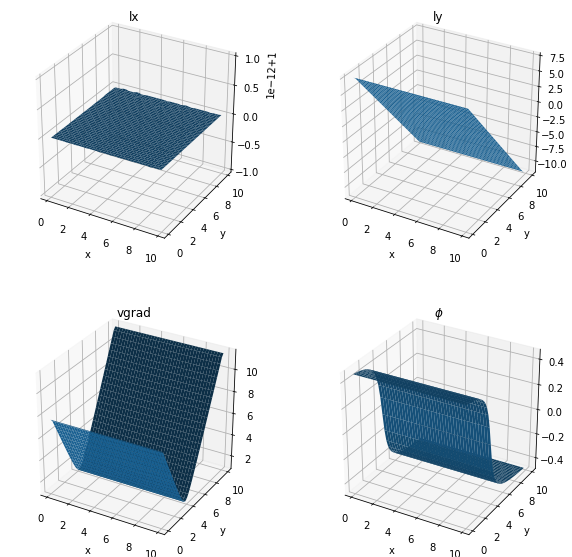

In [63]:
fig = plt.figure(figsize = (10, 10))


def _plot(i, var, name, nx, ny):
    ax0 = fig.add_subplot(nx, ny, i + 1, projection = '3d')
    ax0.plot_surface(*xmesh, var)
    plt.xlabel('x'); plt.ylabel('y'); plt.title(name)

vars = (lx, 'lx'), (ly, 'ly'), (vgrad, 'vgrad'), (phi, r'$\phi$')

for i, var in enumerate(vars):
    _plot(i, *var, 2, 2)

*Notes*
   
   * Use the steps when computing the gradient with numpy, it can use also arrays with the centers values!


### Hessian

In [64]:
lxx, lxy, lyy = hess[..., 0, 0], hess[..., 0, 1], hess[..., 1, 1]
l1, l0        = leig[..., 0], leig[..., 1]
ulap          = lxx + lyy
print('lxx ', np.mean(lxx), ', lyy ', np.mean(lyy), ', lxy ', np.mean(lxy))
print('laplacian ', np.mean(lap), np.mean(ulap), ', true? ', np.all(np.isclose(ulap, lap)))
print('l1 ', np.mean(l1), ', l0 ', np.mean(l0))

lxx  9.730698631684143e-16 , lyy  -1.9268292682926949 , lxy  -6.783191894356138e-17
laplacian  -1.9268292682926937 -1.9268292682926937 , true?  True
l1  -1.9268292682926949 , l0  9.73069863168442e-16


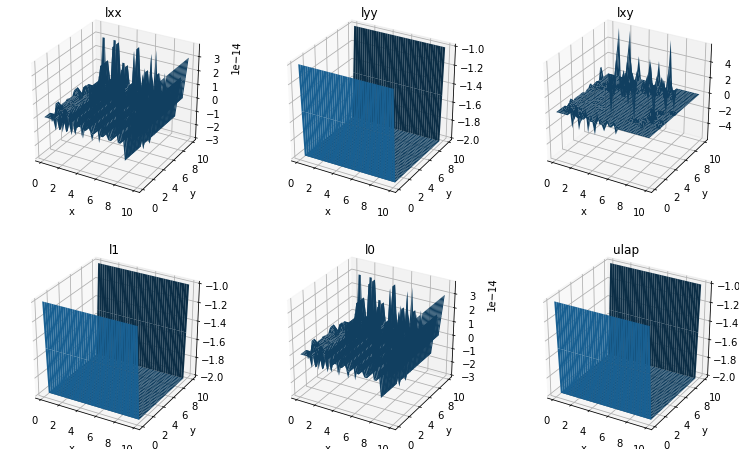

In [65]:
fig = plt.figure(figsize = (13, 8))

vars = ((lxx, 'lxx'), (lyy, 'lyy'), (lxy, 'lxy'), (l1, 'l1'), (l0, 'l0'), (ulap, 'ulap'))

for i, var in enumerate(vars):
    _plot(i, *var, 2, 3)
    

### Eigen vectors

In [66]:
print('eingen vector array shape ', eeig.shape)

eingen vector array shape  (41, 41, 2, 2)


In [67]:
ndim = eeig.shape[-1]
leis = [leig[..., i] for i in range(ndim)]
eis  = [eeig[..., i] for i in range(ndim)]
for ei in eis: ei[np.isclose(ei, 0)] = 0
veis  = [np.sqrt(np.sum(ei * ei, axis = ndim)) for ei in eis]
print(' leis ', [np.mean(lei[i]) for lei in leis])
print(' veis ', [np.mean(vei[i]) for vei in veis])
k = 20
for i in range(2):
    print('i ', i, ', ei ', eeig[k, k, :, i], ', li ', leig[k, k, i])

 leis  [-1.9268292682926933, 1.010302952408917e-15]
 veis  [1.0, 1.0]
i  0 , ei  [0. 1.] , li  -1.9999999999999944
i  1 , ei  [1. 0.] , li  -3.641531520770514e-15


In [68]:
e0 = eeig[..., -1]
e0[np.isclose(e0, 0)] = 0
e1 = eeig[...,  0]
e1[np.isclose(e0, 0)] = 0

uu   = np.sum( e0 * e1, axis = ndim)
uu[np.isclose(uu, 0.)] = 0.
beta = np.arccos(uu)/np.pi

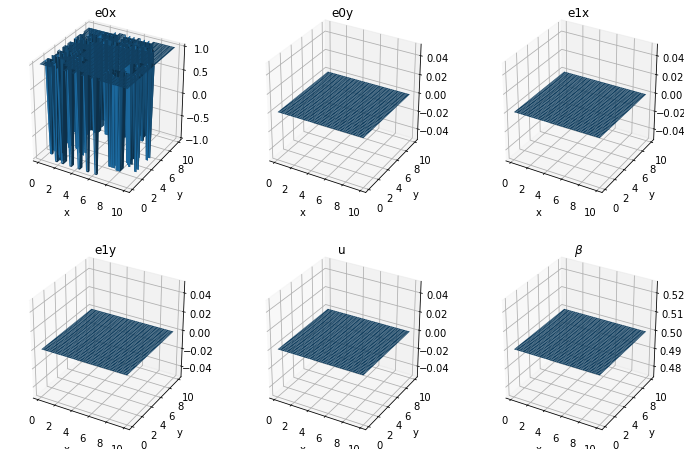

In [69]:
fig = plt.figure(figsize = (12, 8))
nx, ny = 2, 3

vars = ((e0[..., 0], 'e0x'), (e0[..., 1], 'e0y'), (e1[..., 0], 'e1x'),
        (e0[..., 1], 'e1y'), (uu, 'u'), (beta, r'$\beta$'))

for i, var in enumerate(vars): _plot(i, *var, nx, ny)

**Note**

   * To avoid edge problems, maybe extend the cells of clouds (+2, -2)

## Ridge

   * The main einvalue is the last one
  
   * Compute the scalar product with the unitary gradient
 

In [70]:
for fu in fus    : fu  [np.isclose(fu  , 0)] = 0
for beta in betas: beta[np.isclose(beta, 0)] = 0

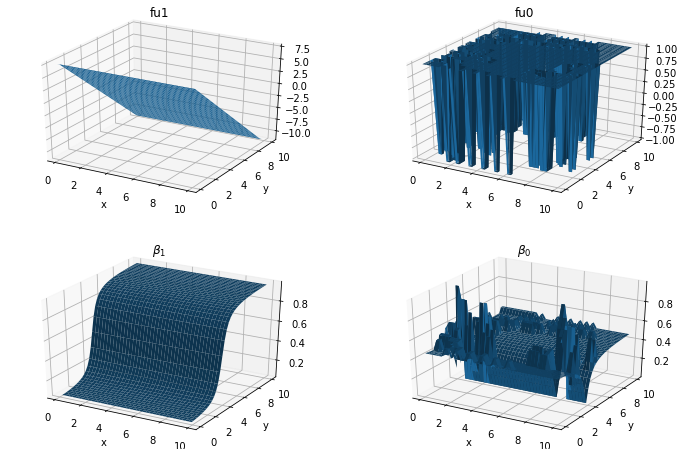

In [71]:
fig = plt.figure(figsize = (12, 8))
nx, ny = 2, 2

vars = ((fus[0], 'fu1'), (fus[1], 'fu0'),
        (betas[0], r'$\beta_1$'), (betas[1], r'$\beta_0$'))
for i, var in enumerate(vars): _plot(i, *var, nx, ny)

## Ridge filter

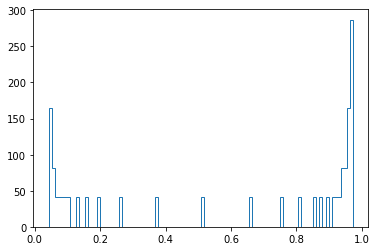

In [72]:
plt.hist(betas[0].flatten(), 100, histtype = 'step');

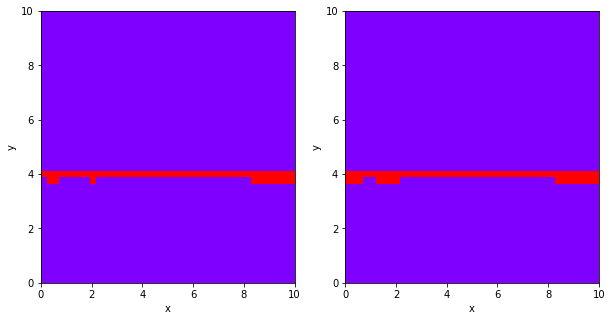

In [73]:
plt.figure(figsize = (10, 5));

plt.subplot(1, 2, 1)
fu1  = abs(fus[0])
ucut = np.percentile(fu1, 3.)
sel  = (fu1 <= ucut)
plt.hist2d(xmesh[0].flatten(), xmesh[1].flatten(), bins, weights = sel.flatten())
plt.xlabel('x'); plt.ylabel('y');

plt.subplot(1, 2, 2)
ubeta = np.abs(betas[0] - 0.5)
ucut = np.percentile(ubeta, 3.)
sel  = (ubeta <= ucut)
plt.hist2d(xmesh[0].flatten(), xmesh[1].flatten(), bins, weights = sel.flatten())
plt.xlabel('x'); plt.ylabel('y');

# 3D

In [74]:
y0, z0 = 5, 3
# Test gradient with this funciton
fun    = lambda x, y, z:  x  - y  + 0.5 * z
# Test ridge with the finction
fun    = lambda x, y, z:  x  - (y - y0)**2  - 0.5 * (z - z0)**2

xrange = (0, 10)
yrange = (0, 10)
zrange = (0, 10)
nbins  = 41

In [75]:
bins, _, img, xmesh = tridges.generate_image(nbins, (xrange, yrange, zrange), fun)
centers = [clouds.ut_centers(ibin) for ibin in bins]

In [76]:
#print(xmesh[0][:, 0, 0])
#print(xmesh[1][0, :, 0])
#print(xmesh[2][0, 0, :])

In [77]:
x         = img
steps = [bin[1] - bin[0] for bin in bins]
print('steps ', steps)

ndim       = x.ndim
grad       = ridges.gradient(x, centers)
vgrad      = np.sqrt(np.sum(grad * grad, axis = ndim))
hess       = ridges.hessian(x, centers)
leig, eeig = np.linalg.eigh(hess)
lap        = ridges.laplacian(hess)    

gradsph    = ridges.vector_in_spherical(grad)
e0sph      = ridges.vector_in_spherical(eeig[..., -1])
fus        = [np.sum(eeig[..., i] * grad, axis = ndim) for i in range(ndim)]
betas      = [np.arccos(fu/vgrad)/np.pi for fu in fus]

steps  [0.24390243902439024, 0.24390243902439024, 0.24390243902439024]


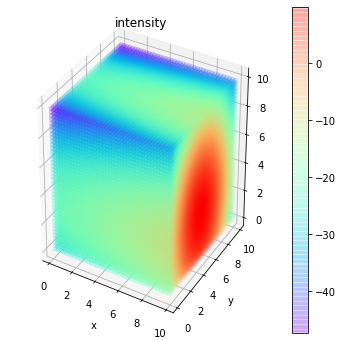

In [123]:
fig = plt.figure(figsize = (6, 6))

def _plot3d(i, var, name, nx, ny):
    ax  = fig.add_subplot(nx, ny, i + 1, projection = '3d')
    p = ax.scatter(*xmesh, '.', c = var.flatten(), alpha = 0.2);
    plt.xlabel('x'); plt.ylabel('y'); plt.title(name); plt.colorbar(p);

counts, _ = np.histogramdd([x.flatten() for x in xmesh], bins, weights = img.flatten())
assert (np.all(counts == img)) # Test the the img is the same ad the histogram


_plot3d(0, img, 'intensity', 1, 1)

### Test meshes

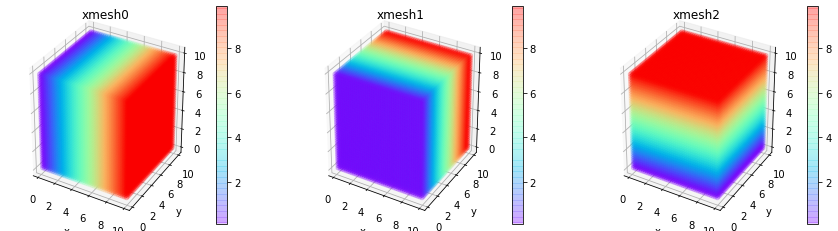

In [99]:
cells_select = clouds.cells_select
fig = plt.figure(figsize = (15, 4))

vars = [(xmesh[i].flatten(), 'xmesh'+str(i)) for i in range(3)]

for i, var, in enumerate(vars): _plot3d(i, *var, 1, 3)


### Test selections

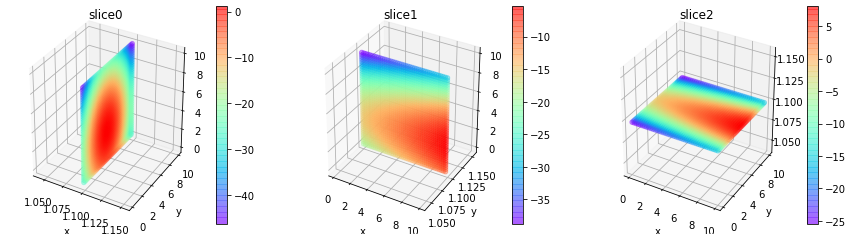

In [98]:
cells_select = clouds.cells_select
fig = plt.figure(figsize = (15, 4))

a, b = 1, 1.2

for i in range(3):
    ax  = fig.add_subplot(1, 3, i + 1, projection = '3d')
    sel = (a < xmesh[i]) & (xmesh[i] < b)
    p = ax.scatter(*cells_select(xmesh, sel), '.', c = img[sel], alpha = 0.4);
    plt.xlabel('x'); plt.ylabel('y'); plt.title('slice'+str(i)); plt.colorbar(p);

### Gradient

In [81]:
lx, ly, lz = grad[..., 0], grad[..., 1], grad[..., 2]
uvgrad, phi = gradsph[0], gradsph[1]
print('lx ', np.mean(lx), ', ly ', np.mean(ly), ', lz ', np.mean(lz))
print('vgrad in sperical? ', np.mean(vgrad), np.mean(uvgrad), ', true? ', np.all(vgrad  == gradsph[0]))
phi    = np.arctan2(ly, lx)/np.pi
lr     = np.sqrt(lx * lx + ly * ly)
theta  = np.arctan2(lz, lr)/np.pi
phi[np.isclose(phi, 0.)] = 0.
print('phi angle', np.mean(phi), np.mean(gradsph[1]), ', true?', np.all(phi  == gradsph[1]))
theta[np.isclose(theta, 0.)] = 0.
print('theta angle', np.mean(theta), np.mean(gradsph[2]), ', true?', np.all(theta  == gradsph[2]))
vgrad, phi, theta  = gradsph[0], gradsph[1], gradsph[2]

lx  1.0 , ly  6.301181353964295e-16 , lz  -2.0
vgrad in sperical?  6.309458790486419 6.309458790486419 , true?  True
phi angle 1.2371429359877544e-17 1.2371429359877544e-17 , true? True
theta angle -0.10553146715585282 -0.10553146715585282 , true? True


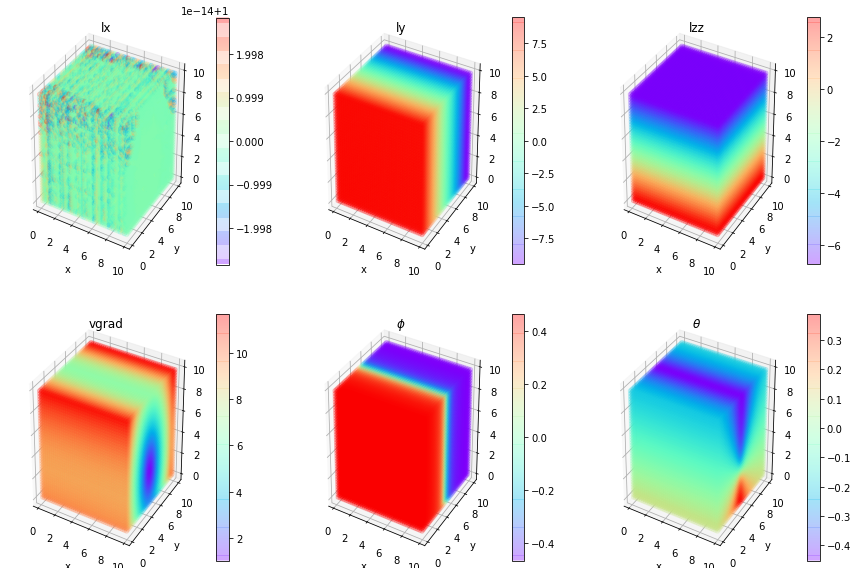

In [101]:
fig = plt.figure(figsize = (15, 10))

vars = (lx, 'lx'), (ly, 'ly'), (lz, 'lzz'), (vgrad, 'vgrad'), (phi, r'$\phi$'), (theta, r'$\theta$'), 

for i, var in enumerate(vars):
    _plot3d(i, *var, 2, 3)

## hessian

In [102]:
lxx, lyy, lzz = hess[..., 0, 0], hess[..., 1, 1], hess[..., 2, 2]
lxy, lxz, lyz = hess[..., 0, 1], hess[..., 0, 1], hess[..., 1, 2]
l1, l2, l0    = leig[..., 0], leig[..., 1], leig[..., 2]
for li in (l1, l2, l0):
    li [np.isclose(li, 0.)]  = 0.
ulap          = lxx + lyy + lzz
print('lxx ', np.mean(lxx), ', lyy ', np.mean(lyy), ', lzz ', np.mean(lzz))
print('lxy ', np.mean(lxy), ', lxz ', np.mean(lyz), ', lyz ', np.mean(lyz))
print('laplacian ', np.mean(lap), ', true? ', np.all(np.isclose(ulap, lap)))
print('l1 ', np.mean(l1), ', l2 ', np.mean(l2), ', l0', np.mean(l0))

lxx  -2.2140348137226757e-16 , lyy  -1.9268292682926846 , lzz  -0.9634146341463417
lxy  1.5112313091105772e-17 , lxz  9.283968411621055e-18 , lyz  9.283968411621055e-18
laplacian  -2.890243902439027 , true?  True
l1  -1.9268292682926864 , l2  -0.9634146341463404 , l0 0.0


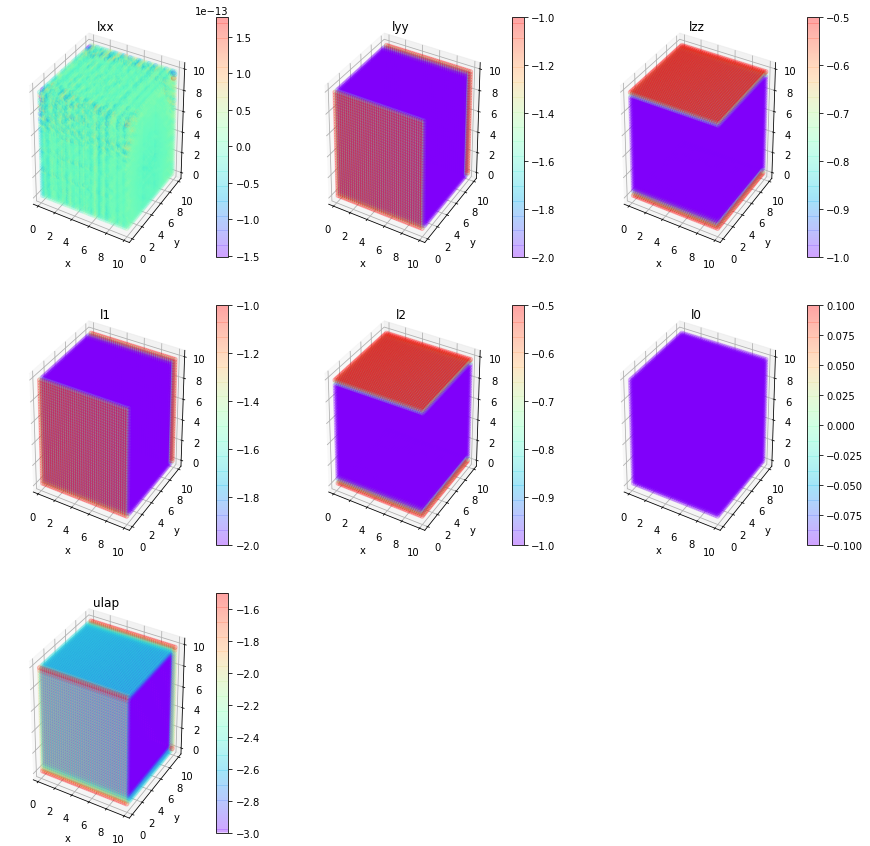

In [103]:
fig = plt.figure(figsize = (15, 15))

vars = ((lxx, 'lxx'), (lyy, 'lyy'), (lzz, 'lzz'),
        (l1, 'l1'), (l2, 'l2'), (l0, 'l0'),
        (ulap, 'ulap'))

for i, var in enumerate(vars):
    _plot3d(i, *var, 3, 3)
    

### Eigen vectors

In [104]:
ndim = hess.shape[-1]
leis = [leig[..., i] for i in range(ndim)]
eis  = [eeig[..., i] for i in range(ndim)]
for ei in eis: ei[np.isclose(ei, 0)] = 0
veis  = [np.sqrt(np.sum(ei * ei, axis = ndim)) for ei in eis]
print(' leis ', [np.mean(lei[i]) for lei in leis])
print(' veis ', [np.mean(vei[i]) for vei in veis])
k = 20
for i in range(ndim):
    print('i ', i, ', ei ', eeig[k, k, k, :, i], ', li ', leig[k, k, k, i])

 leis  [-1.9268292682926862, -0.9634146341463401, 0.0]
 veis  [1.0, 1.0, 1.0]
i  0 , ei  [0. 1. 0.] , li  -2.0
i  1 , ei  [0. 0. 1.] , li  -1.0000000000000002
i  2 , ei  [-1.  0.  0.] , li  0.0


### Ridge

In [105]:
for fu in fus    : fu  [np.isclose(fu  , 0)] = 0
for beta in betas: beta[np.isclose(beta, 0)] = 0

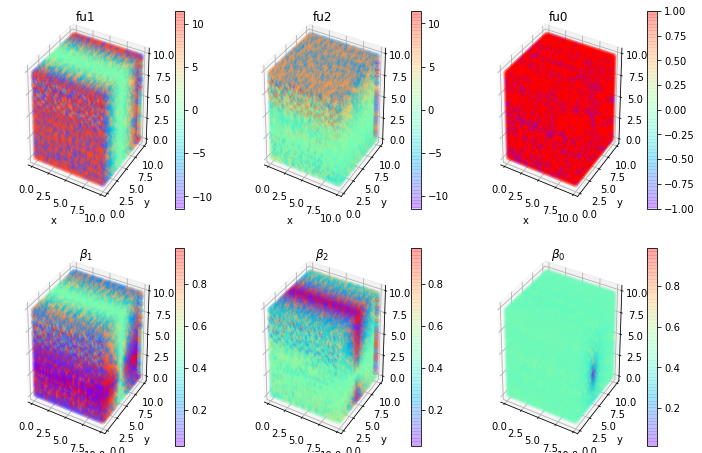

In [106]:
fig = plt.figure(figsize = (12, 8))
nx, ny = 2, 3

vars = ((fus[0], 'fu1'), (fus[1], 'fu2'), (fus[2], 'fu0'),
        (betas[0], r'$\beta_1$'), (betas[1], r'$\beta_2$'), (betas[2], r'$\beta_0$'))
for i, var in enumerate(vars): _plot3d(i, *var, nx, ny)

### Ridge Filter

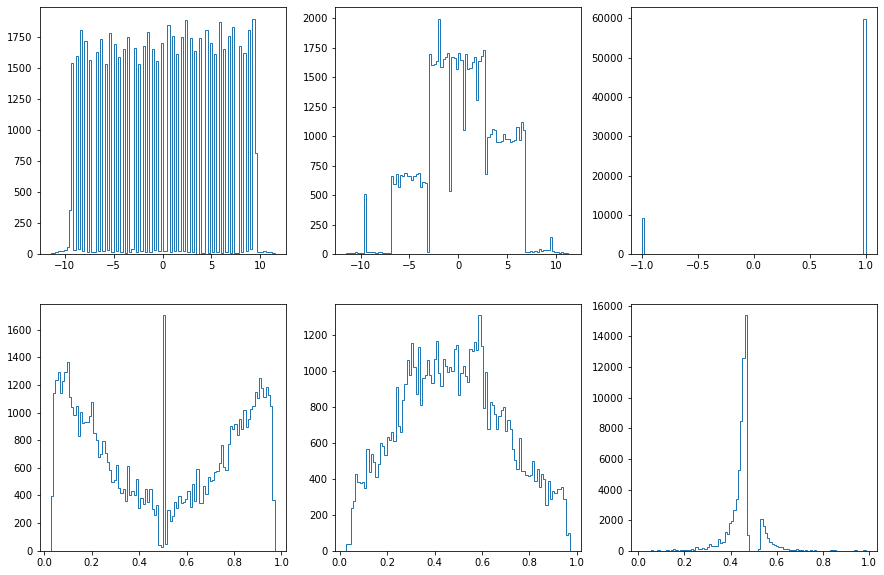

In [112]:
plt.figure(figsize = (15, 10))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.hist(fus[i]  .flatten(), 100, histtype = 'step');
    plt.subplot(2, 3,  i + 4)
    plt.hist(betas[i].flatten(), 100, histtype = 'step');

points in ridge 0  3459
points in ridge 1  3447
points in ridge    205


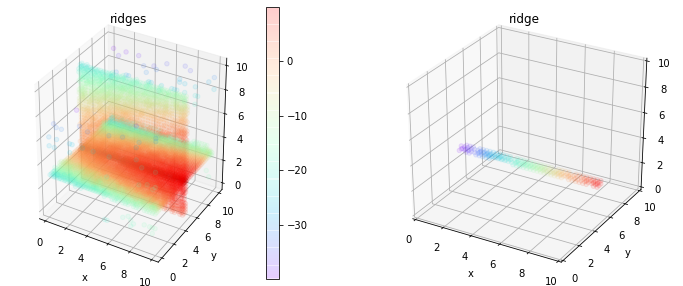

In [145]:
plt.figure(figsize = (12, 5));
nx, ny = 1, 3

def _filter(val, perc = 5):
    cut = np.percentile(val, perc)
    return val <= cut

sel0 = _filter(np.abs(fus[0]))
print('points in ridge 0 ', np.sum(sel0 == True))
sel1 = _filter(np.abs(fus[1]))
print('points in ridge 1 ', np.sum(sel1 == True))
sel  = sel0 & sel1
print('points in ridge   ', np.sum(sel  == True))

vars = ((sel0.astype(int), 'ridge1'), (sel1.astype(int), 'ridge2'), (sel.astype(int), 'ridge'))

ax  = plt.subplot(1, 2, 1, projection = '3d');
p = ax.scatter(*cells_select(xmesh, sel), '.' , c = 'black', alpha = 0.1);
p = ax.scatter(*cells_select(xmesh, sel0), '.', c = img[sel0], alpha = 0.1);
p = ax.scatter(*cells_select(xmesh, sel1), '.', c = img[sel1], alpha = 0.1);
plt.xlabel('x'); plt.ylabel('y'); plt.title('ridges'); plt.colorbar(p)

ax  = plt.subplot(1, 2, 2, projection = '3d');
p = ax.scatter(*cells_select(xmesh, sel), '.', c = img[sel], alpha = 0.1);
ax.set_xlim((bins[0][0], bins[0][-1])); ax.set_ylim((bins[1][0], bins[1][-1]));
ax.set_zlim((bins[2][0], bins[2][-1]))
plt.xlabel('x'); plt.ylabel('y'); plt.title('ridge');